In [1]:
### Notebook for P3D stuff!
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import jax
jax.config.update('jax_platform_name', 'gpu')
from jax.lib import xla_bridge
print("jax version",jax.__version__)
print(xla_bridge.get_backend().platform)

import numpy as np
import jax.numpy as jnp 

%pylab inline

jax version 0.4.26
gpu
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
!nvidia-smi


Fri Mar 28 19:45:01 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      Off| 00000000:1A:00.0 Off |                  N/A |
| 16%   26C    P8                1W / 250W|     18MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

/home/guoqi/.conda/envs/MAPLE/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


|   2  Tesla V100-PCIE-32GB            Off| 00000000:1F:00.0 Off |                    0 |
| N/A   35C    P0               25W / 250W|      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
|   3  Tesla V100-PCIE-32GB            Off| 00000000:20:00.0 Off |                    0 |
| N/A   38C    P0               38W / 250W|    312MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
|   4  Tesla V100-PCIE-32GB            Off| 00000000:21:00.0 Off |                    0 |
| N/A   36C    P0               26W / 250W|      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------

In [3]:
#from jaxpm.kernels import *
#uses jaxpm for some kernels... maybe?

In [4]:
#First things... set the redshift

z= 2.0

#set box geometry, probably should wrap this into the fiducial model file (hdf5?) to lead to less fiddling bugs

bs =  50#box size in Mpc/h
nc =  100#number of pixels per side

mesh_shape = [nc,nc,nc]
box_size = [bs,bs,bs]

ptcl_grid_shape = (nc,) * 3
ptcl_spacing = bs/nc



In [5]:
#some fourier space routines
from helper_functions import *

kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
k = jnp.sqrt(sum(k**2 for k in kvec))
#this vector is needed for lots of fourier space transformation operations later on...
print(k.shape)

/tmp/ipykernel_165818/2721841557.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  k = jnp.sqrt(sum(k**2 for k in kvec))
2025-03-28 19:45:07.417726: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.8.93). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(100, 100, 51)


In [6]:
#in this setup, LOS (z) is along the 0 axis, be careful when loading in data!

kz = jnp.ones(k.shape)*kvec[0]**2

kx = jnp.ones(k.shape)*(kvec[1]**2+kvec[2]**2)
#tiny deltas are added to avoid div by zero errors
kk = (kx+kz)+10**(-8)
kmu = jnp.sqrt((kz/(k**2+0.00001)))


In [7]:
np.max(k)


Array(10.882796, dtype=float32)

In [8]:
#m_array[:,0][:50].max()
from jax import jit, checkpoint, custom_vjp
from jax.scipy.ndimage import map_coordinates

#loading in fiducial model
m_array = np.load("pkell_red_50.npy")
m_array = jnp.array(m_array[np.where(m_array[:,1]<=8)])
kmax = m_array[-1,0]
print(m_array.shape,kmax)


(100, 3) 15.607467


In [9]:
import jaxinterp2d

k_in = (k.flatten()/kmax*19-0.1)

l0 = np.where(m_array[:,1]==0)[0]
k_l0 = m_array[l0,0]
Pk_l0 = m_array[l0,2]
func1 = map_coordinates(Pk_l0,np.array([k_in]),mode="nearest",order=1)
func1 = func1.reshape(k.shape[0],k.shape[1],k.shape[2])

l2 = np.where(m_array[:,1]==2)[0]
k_l2 = m_array[l2,0]
Pk_l2 = m_array[l2,2]
func2 = map_coordinates(Pk_l2,np.array([k_in]),mode="nearest",order=1)
func2 = func2.reshape(k.shape[0],k.shape[1],k.shape[2])

l4 = np.where(m_array[:,1]==4)[0]
k_l4 = m_array[l4,0]
Pk_l4 = m_array[l4,2]
func4 = map_coordinates(Pk_l4,np.array([k_in]),mode="nearest",order=1)
func4 = func4.reshape(k.shape[0],k.shape[1],k.shape[2])

l6 = np.where(m_array[:,1]==6)[0]
k_l6 = m_array[l6,0]
Pk_l6 = m_array[l6,2]
func6 = map_coordinates(Pk_l6,np.array([k_in]),mode="nearest",order=1)
func6 = func6.reshape(k.shape[0],k.shape[1],k.shape[2])

l8 = np.where(m_array[:,1]==8)[0]
k_l8 = m_array[l8,0]
Pk_l8 = m_array[l8,2]
func8 = map_coordinates(Pk_l8,np.array([k_in]),mode="nearest",order=1)
func8 = func8.reshape(k.shape[0],k.shape[1],k.shape[2])


In [10]:
k_l0

Array([ 0.5939411,  1.2859824,  2.0516453,  2.8347514,  3.6281013,
        4.424479 ,  5.2197375,  6.0153003,  6.814117 ,  7.6137304,
        8.412382 ,  9.211254 , 10.010572 , 10.809766 , 11.609148 ,
       12.408537 , 13.207074 , 14.007173 , 14.807906 , 15.607467 ],      dtype=float32)

In [10]:
from scipy.special import legendre

# np.min(func1*legendre(0)(kmu)+func2*legendre(2)(kmu)+func4*legendre(4)(kmu)+func6*legendre(6)(kmu)+func8*legendre(8)(kmu))

In [11]:
k_ind_optim_max = 14
ell_bins=5
k_bins=20
tff = m_array[:,2].reshape(ell_bins,k_bins)
theta_fid = m_array[:,2].reshape(ell_bins,k_bins)[:,:k_ind_optim_max]
# theta_fid = m_array[:k_bins,2].reshape(1,k_bins)[:,:k_ind_optim_max]

from scipy.special import legendre

def power_b(theta,tff=tff):    
    tff = tff.at[:,:k_ind_optim_max].set(theta.reshape(ell_bins,k_ind_optim_max))
    # tff = tff.at[0,:k_ind_optim_max].set(theta.reshape(1,k_ind_optim_max).ravel())
    func1 = map_coordinates(tff[0], np.array([k_in]), mode="nearest", order=1)
    func1 = func1.reshape(k.shape[0],k.shape[1],k.shape[2])
    func2 = map_coordinates(tff[1], np.array([k_in]), mode="nearest", order=1)
    func2 = func2.reshape(k.shape[0],k.shape[1],k.shape[2])
    func4 = map_coordinates(tff[2], np.array([k_in]), mode="nearest", order=1)
    func4 = func4.reshape(k.shape[0],k.shape[1],k.shape[2])
    func6 = map_coordinates(tff[3], np.array([k_in]), mode="nearest", order=1)
    func6 = func6.reshape(k.shape[0],k.shape[1],k.shape[2])
    func8 = map_coordinates(tff[4], np.array([k_in]), mode="nearest", order=1)
    func8 = func8.reshape(k.shape[0],k.shape[1],k.shape[2])
    func = jax.nn.relu(func1*legendre(0)(kmu)+func2*legendre(2)(kmu)+func4*legendre(4)(kmu)+func6*legendre(6)(kmu)+func8*legendre(8)(kmu))
    # func = jax.nn.relu(func1*legendre(0)(kmu)+func2*legendre(2)(kmu)+func4*legendre(4)(kmu))
    return func*8


In [12]:
#muse componenet...
from functools import partial
import jax
import jax.numpy as jnp
from muse_inference.jax import JaxMuseProblem

In [13]:

#file name
prefix = "V1_DENSE_"
loc = "./configs/"

naa = np.load(loc+prefix+"naa.npy")
kernel = np.load(loc+prefix+"kernel.npy")
skewers_skn = np.load(loc+prefix+"skewers_skn.npy")
skewers_dla = np.load(loc+prefix+"skewers_dla.npy")
skewers_fin = np.load(loc+prefix+"skewers_fin.npy")



@jit
def cic_readout_jit_jnc(mesh,naa,kernel,bs=False):
    #"highly optimized" CIC, need to preprocess lots of things... don't diff output coords
    meshvals = mesh.flatten()[naa].reshape(-1,8).T#mesh[tuple(neighboor_coords[0,:,:].T.tolist())]
    weightedvals = meshvals.T* kernel[0]
    values = np.sum(weightedvals, axis=-1)
    
    return values



In [14]:
tf_cut_flat = theta_fid.flatten()

noise_level = 1.0

def gen_map_lya(theta,z):
    modes = z[:nc**3].reshape((nc,nc,nc))    
    Plin = power_b(theta)
    conv_field = jnp.fft.rfftn(modes).conj()*Plin**(1/2)
    lin_modes_real = jnp.fft.irfftn(conv_field).T[:,:,:]

    lya_values = cic_readout_jit_jnc(lin_modes_real,naa,kernel)
    return lya_values
                 
class Jax3DMuseProblem_flat(JaxMuseProblem):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    #@jax.jit
    def sample_x_z(self, key, θ):
        keys = jax.random.split(key, 2)
        z = jax.random.normal(keys[0], (nc*nc*nc,))
        
        x = gen_map_lya(θ,z) + (0.05*skewers_skn)*jax.random.normal(keys[1], (kernel.shape[1],)) #1*jax.random.normal(keys[1], (32**3,)).reshape((32,32,32))
   #     print(z.shape,x.shape)
        return (x, z)

  #  @jax.jit
    def logLike(self, x, z, θ):
        return -(jnp.sum((x - gen_map_lya(θ,z))**2/((0.05*skewers_skn)**2))+ jnp.sum(z**2.0))

  #  @jax.jit
    def logPrior(self, θ):
        return -jnp.sum(((θ-jnp.array(tf_cut_flat)*1.1)**2 / (2*(tf_cut_flat*0.4)**2)))
    


In [15]:
prob = Jax3DMuseProblem_flat(implicit_diff=True,jit=False)
key = jax.random.PRNGKey(100)
(x, z) = prob.sample_x_z(key, tf_cut_flat)
prob.set_x(x)

In [16]:
modes = z[:nc**3].reshape((nc,nc,nc))    
Plin = power_b(tf_cut_flat)
conv_field = jnp.fft.rfftn(modes).conj()*Plin**(1/2)
lin_modes_real = jnp.fft.irfftn(conv_field).T[:,:,:]

np.save("example_gen_field",lin_modes_real)

In [17]:
rng = jax.random.PRNGKey(1)

In [18]:
x_data = x

In [19]:
from numpy.random import SeedSequence, default_rng
from copy import copy

start_point = jnp.array(tf_cut_flat)*1.2#+np.random.randn(len(tf_cut_flat))*jnp.array(tf_cut_flat)*0.01)

def _split_rng(rng, N):
    keyz = []
    for i in range(N):
        rng, subkey = jax.random.split(rng)
        keyz.append(rng)
    return keyz
    
θ = start_point

maxsteps = 100
nsims= 10
rng = jax.random.PRNGKey(1)

xz_sims = [prob.sample_x_z(_rng, θ) for _rng in _split_rng(rng, nsims)]
xs = [x_data] + [x for (x,_) in xz_sims]
ẑs = [z*0]     + [z*0 for (x, z) in xz_sims]

In [20]:
print(x_data)

[ 0.02628885 -0.02079643  0.06844728 ...  0.0280249   0.03865367
 -0.1401071 ]


In [21]:
from jax import grad, hessian, jacfwd, jvp, value_and_grad, vmap

def gradθ_hessθ_logPrior(θ, transformed_θ=None):
        g = grad(prob.logPrior)(θ)
        H = hessian(lambda θ_vec: prob.logPrior(unravel_θ(θ_vec)))(ravel_θ(θ))
        return (g, H)

step: 1 0.7
[[-1.63677780e-10  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.16210375e-10  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.23510620e-11 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.43419637e-10
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -1.81088344e-09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -1.51891825e-07]]
[0.200024   0.20010811 0.1997769  0.19986157 0.19988078 0.19989505
 0.19990453 0.19989032 0.1997517  0.19923462 0.1220331  0.20158689
 0.20648214 0.21877952 0.2000739  0.20026404 0.20052864 0.2013642
 0.20503925 0.17818232 0.19532205 0.19311926 0.20554517 0.20840172
 0.21490929 0.21836373 0.14376235 0.13051556 0.20013814 0.20077004
 0.20070224 0.2011

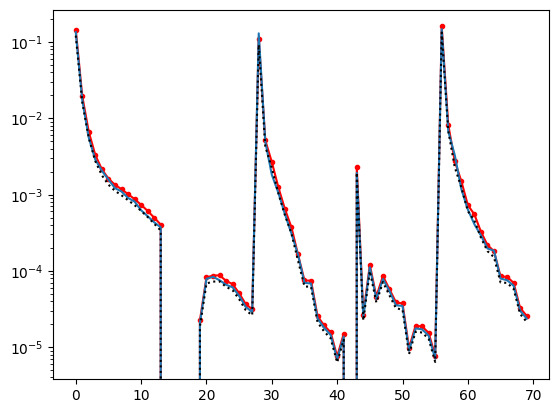

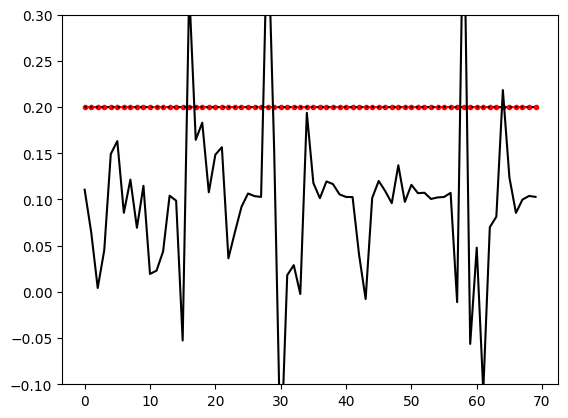

step: 4 0.6649999999999999
[[-3.8883165e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.7431147e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.9546916e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.5053980e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.4131288e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -4.3493612e-03]]
[ 0.0223286  -0.01831482 -0.0480069  -0.12872332 -0.04186272 -0.03022516
 -0.0948867  -0.06498362 -0.10840499 -0.07057229 -0.15008591 -0.14707088
  0.00344671  0.09726731  0.01504739 -0.07865413  0.5475555   0.35818264
  0.3786147   0.04845167 -0.04248041 -0.02791241 -0.0242434   0.05024743
  0.08534919  0.10053542  0.10108755  0.10091905  0.36694255  0.18314707
 -0.3186

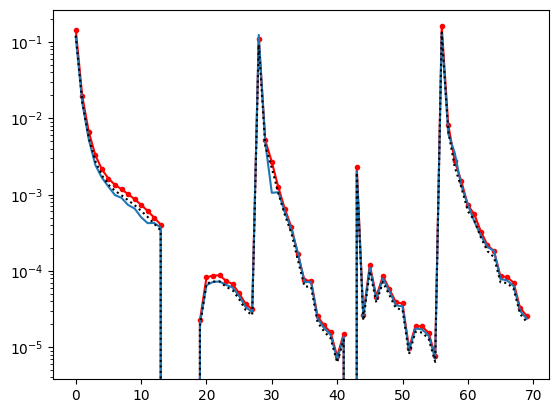

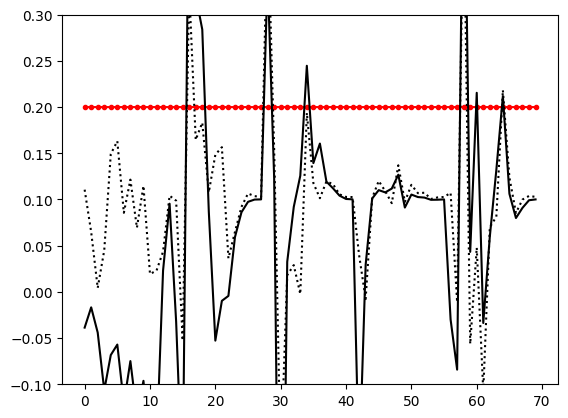

step: 7 0.6317499999999999
[[-1.9931409e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -6.1294969e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.2408871e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.5548466e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -9.4922339e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.2171935e-03]]
[-0.02923341  0.1385415   0.0262303   0.03460487  0.07879861  0.09190175
  0.01825553  0.07119193  0.00387649  0.04647352 -0.04305356 -0.03965883
  0.1434578   0.1004424  -0.13325885 -0.34068552  0.26712084  0.11206465
  0.08117061  0.16924988  0.09685492  0.1467223   0.14070603  0.10913436
  0.0980506   0.09707303  0.09967216  0.10003462  0.29979792  0.08454885
 -0.6011

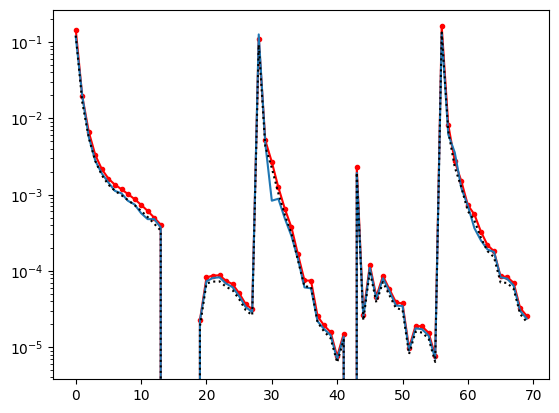

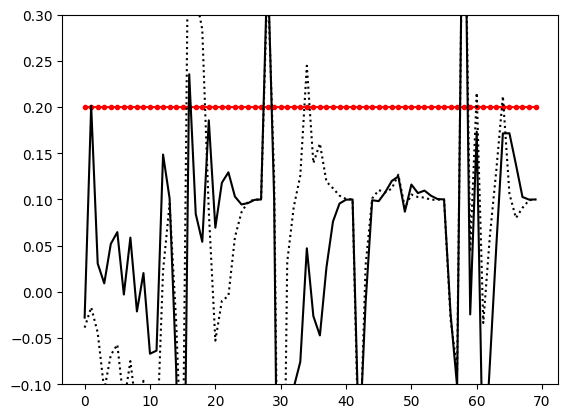

step: 10 0.6001624999999999
[[-3.8381761e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -6.5166142e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.7075458e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.3957930e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2278874e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -4.0207375e-03]]
[-0.07364076  0.11323921 -0.01528705 -0.08643591 -0.10593727 -0.09507793
 -0.15247512 -0.09314769 -0.16802962 -0.13272695 -0.20692317 -0.20410986
  0.06563729  0.09699037 -0.07423206 -0.30217192  0.4208907   0.08406291
  0.12203868  0.1292366  -0.01309008  0.01395313  0.04088927  0.07643818
  0.09029683  0.0972302   0.09977324  0.10000302  0.32123277  0.15649107
 -0.610

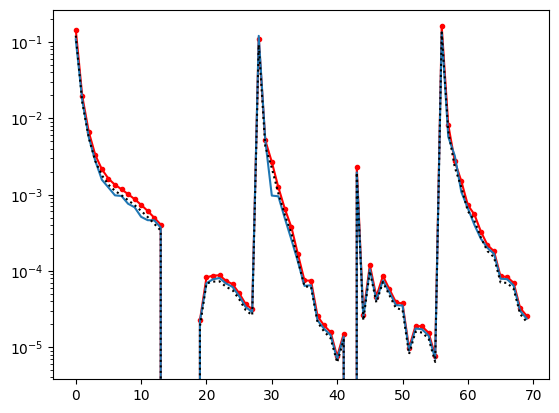

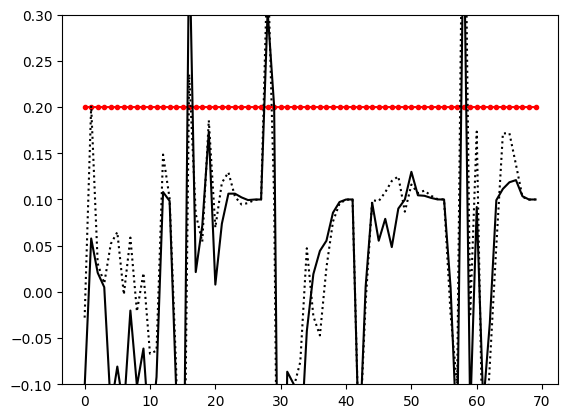

step: 13 0.5701543749999999
[[-1.2808487e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.2332331e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.4648539e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.2248453e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.0300321e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.2234192e-03]]
[-0.09589372  0.11227693  0.05246773  0.13439816 -0.00149507  0.05017538
 -0.00356997  0.10007703  0.0263439   0.07248363 -0.04583813  0.03731643
  0.1435299   0.1005417  -0.14853586 -0.40636402  0.31808716 -0.12416527
 -0.08126438  0.19450836  0.15154956  0.1902084   0.12255425  0.10607735
  0.09947279  0.09813391  0.09981082  0.10000177  0.28340498  0.14834273
 -0.626

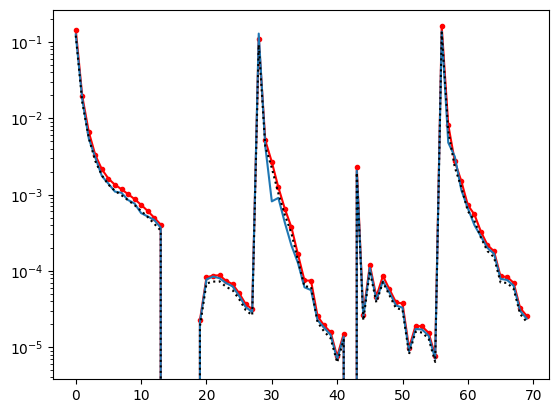

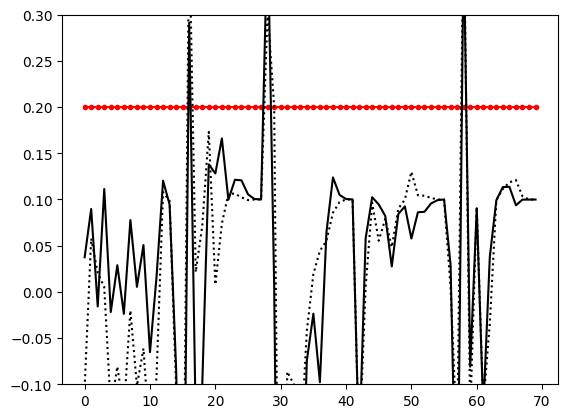

step: 16 0.5416466562499999
[[-3.7169557e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.2554499e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.7855394e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.3183077e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.3778637e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.8186121e-03]]
[-5.91225643e-03  4.61886860e-02 -4.62579615e-02  4.57891487e-02
 -1.54244021e-01 -1.10477954e-01 -1.46599650e-01 -1.46756573e-02
 -1.01981536e-01 -8.25278908e-02 -1.91803575e-01 -1.21369980e-01
  6.79534525e-02  9.48853940e-02 -6.32507727e-02 -3.80956948e-01
  4.66165245e-01 -2.87419315e-02  2.19493601e-02  1.12440795e-01
  2.74482686e-02  7.07457215e-02  6.15872666e-0

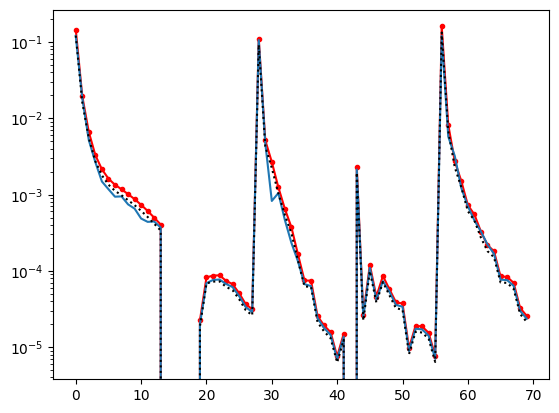

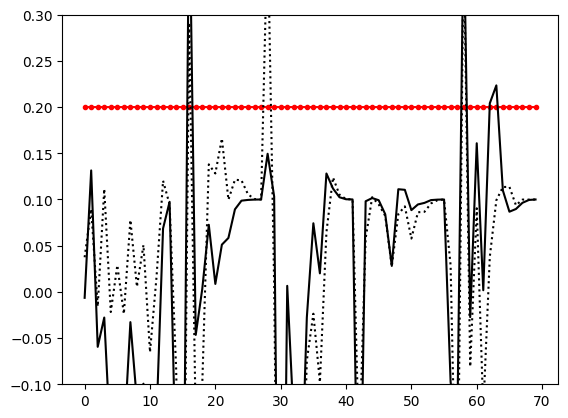

step: 19 0.5145643234374998
[[-3.1746909e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.2521752e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.3944494e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.2715700e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.0598081e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.7050560e-03]]
[-0.13424763  0.19035697  0.05251675  0.09727775 -0.06294809 -0.01445761
 -0.0544786   0.09168611 -0.00504406  0.01650955 -0.1045621  -0.02652539
  0.20616578  0.10902647 -0.30873075 -0.45986193  0.25413054 -0.16920394
 -0.12584352  0.21060541  0.1383571   0.18632838  0.19450021  0.18327089
  0.11763013  0.09841169  0.09956574  0.09999209  0.00159298 -0.03870219
 -0.677

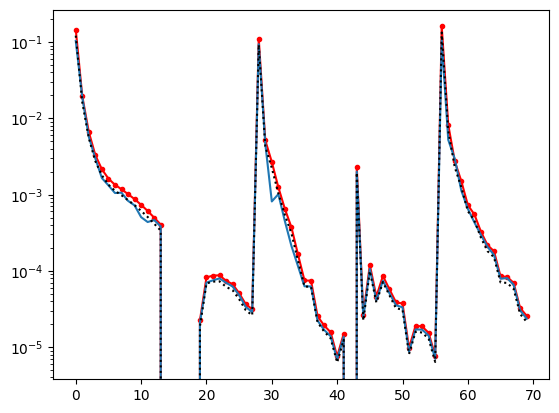

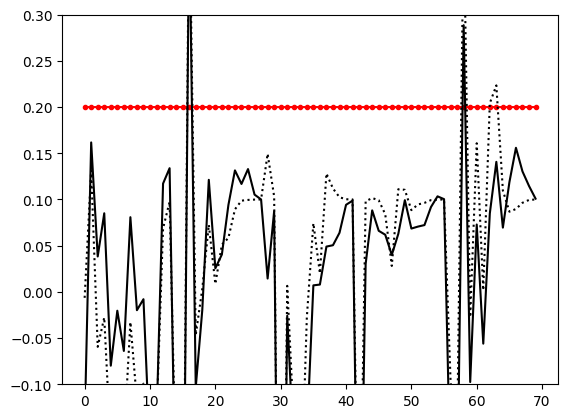

step: 22 0.48883610726562476
[[-3.1682972e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.8876646e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.8270073e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.9829524e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.1933602e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.7201229e-03]]
[-0.15447214  0.10546232  0.01577087  0.07161295 -0.09774503  0.09311721
 -0.05772128  0.0825192  -0.02675083 -0.0018158  -0.18282944 -0.1034975
  0.08653415  0.11574669 -0.24636993 -0.3547524   0.5014852  -0.16142035
 -0.01941126  0.12729463  0.04277115  0.02740103  0.05593246  0.10235856
  0.10393187  0.11583623  0.10263813  0.10002968  0.04402317  0.15931922
 -0.620

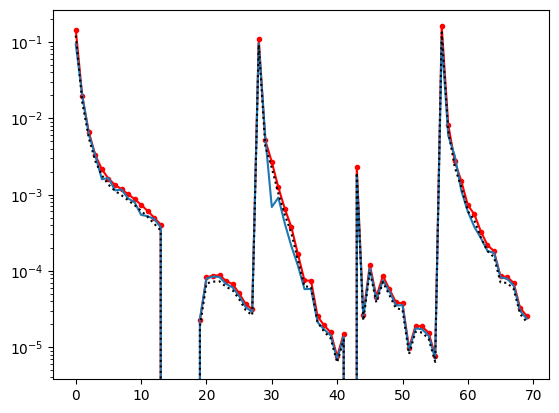

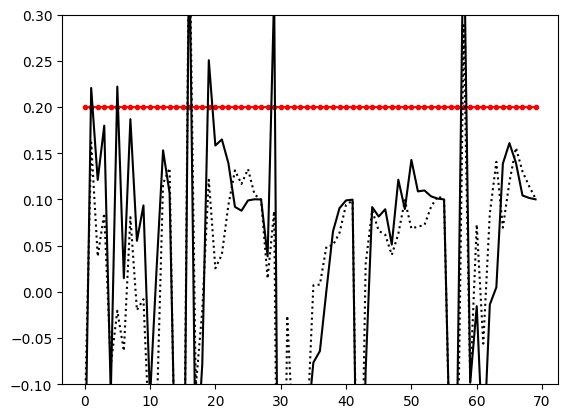

step: 25 0.4643943019023435
[[-3.2517924e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -9.6322196e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.2854672e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.4495755e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.4530250e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -4.2833411e-03]]
[-0.2296264   0.07895952  0.03515494  0.04293287 -0.21440634  0.08025875
 -0.10296296  0.04911019 -0.06720524 -0.03338886 -0.21772566 -0.09505377
  0.055232    0.09977663 -0.23443677 -0.35711363  0.55548036 -0.10144138
  0.02835652  0.15766571  0.02393948  0.02971952  0.03226655  0.06699194
  0.08612919  0.09893619  0.10013746  0.1000072   0.05273778  0.297032
 -0.65602

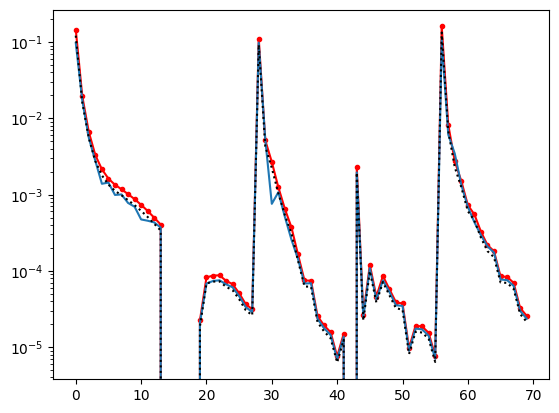

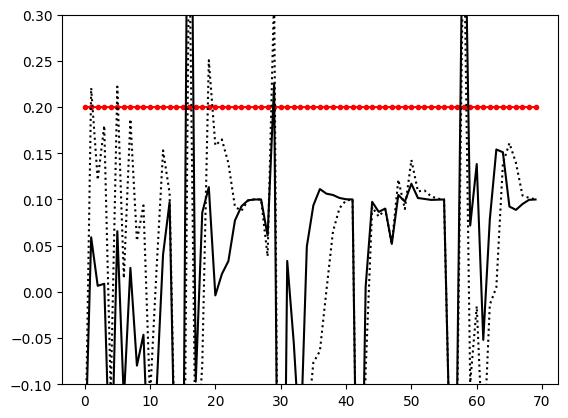

step: 28 0.44117458680722627
[[-2.9398565e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.5625462e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.4713341e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.5892604e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.1348325e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.5479604e-03]]
[-0.17093976  0.12246708  0.02859382  0.07988193 -0.1395171   0.18323778
 -0.01938376  0.13913606  0.02171635  0.05875636 -0.14315291 -0.00878691
  0.08670432  0.09906472 -0.27733034 -0.38525108  0.6005762  -0.19671787
 -0.01037518  0.14008191  0.10604735  0.12619726  0.07832972  0.09207612
  0.0960509   0.09858418  0.09987348  0.10000253  0.05504545  0.19615325
 -0.69

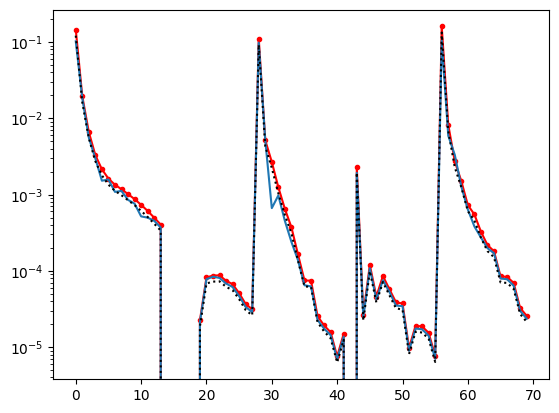

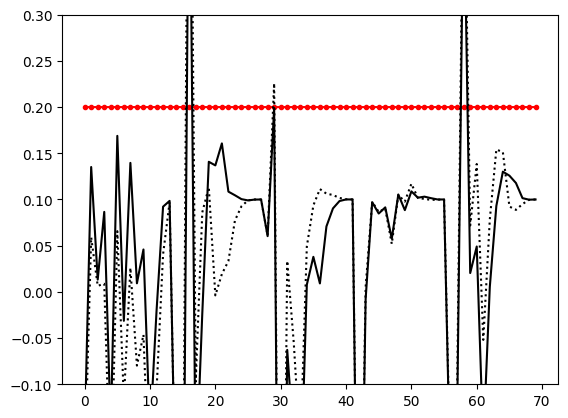

step: 31 0.4191158574668649
[[-3.3144363e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.5178186e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.8025797e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.8580370e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.3535458e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.9854092e-03]]
[-0.16211455  0.08609723 -0.01621372  0.02969241 -0.23904838  0.04637372
 -0.13281074  0.03226221 -0.09646463 -0.06370898 -0.24226362 -0.12343957
  0.06007385  0.09702513 -0.25003523 -0.35504717  0.6479103  -0.12334634
  0.05238857  0.11697496  0.05281331  0.08105966  0.07098244  0.09284526
  0.0978286   0.09913581  0.09991058  0.10000364  0.06744254  0.20665
 -0.670507

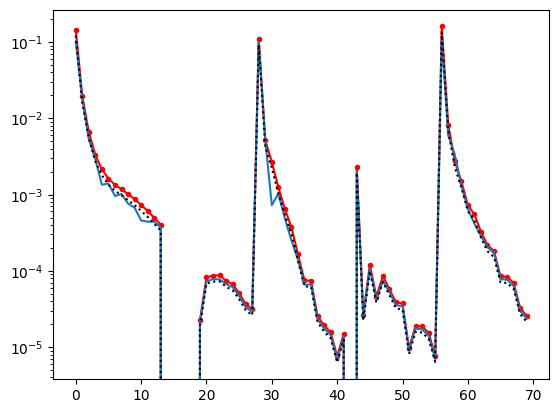

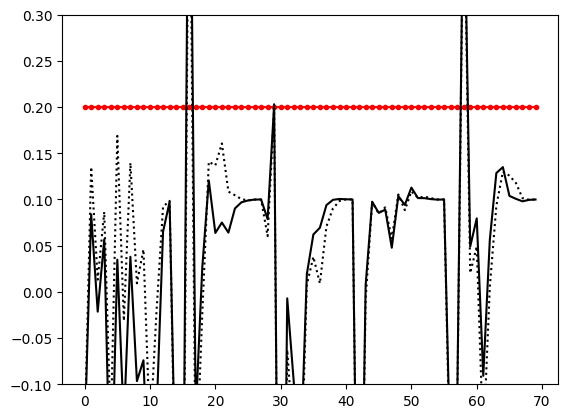

step: 34 0.39816006459352166
[[-2.2429822e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.2831506e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.8875136e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.6796645e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -9.0299443e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.6650745e-03]]
[-0.15200543  0.1239794  -0.00755257  0.10339603 -0.17248905  0.13789852
 -0.0569589   0.14131498 -0.00668304  0.01818712 -0.17598553 -0.04676801
  0.10363876  0.09950479 -0.27765915 -0.3765119   0.54411864 -0.21927494
 -0.06244308  0.14478907  0.1606181   0.15216024  0.11437833  0.11029786
  0.10186599  0.09905124  0.09988169  0.10000587  0.09200829  0.2220811
 -0.655

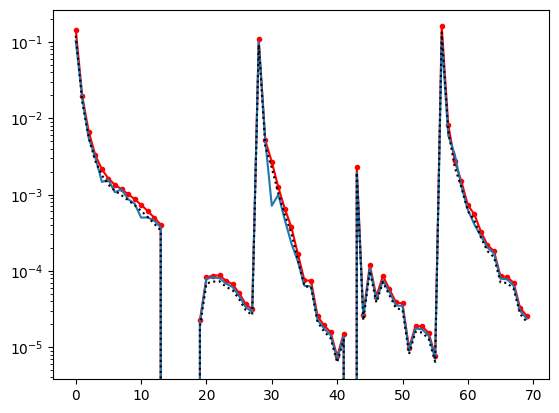

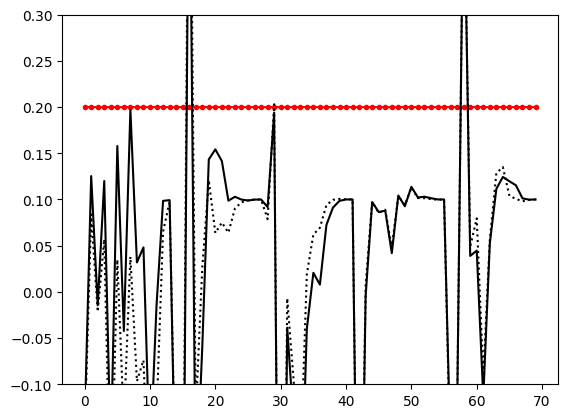

step: 37 0.37825206136384554
[[-3.2459993e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.4622204e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.7028985e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.1931080e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2782673e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.5870473e-03]]
[-0.15138718  0.08709042 -0.04089565  0.06704941 -0.25816476  0.04836164
 -0.1329391   0.11006359 -0.05894722 -0.05096813 -0.26129925 -0.10784112
  0.06459688  0.09750438 -0.243728   -0.34907395  0.64003223 -0.15391433
  0.02187061  0.12022757  0.07107928  0.07895783  0.07106522  0.09421678
  0.0981648   0.09913915  0.09991783  0.10000435  0.09817832  0.20329684
 -0.65

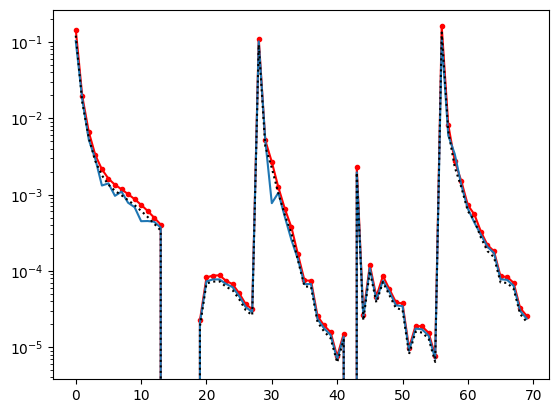

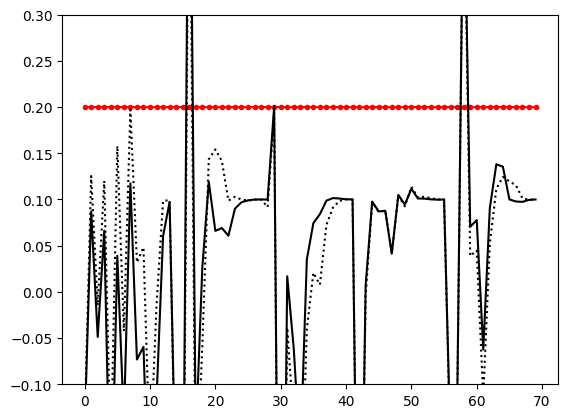

step: 40 0.3593394582956532
[[-3.0504712e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.1521716e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.4615103e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.4722837e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.1393908e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.6146569e-03]]
[-0.13980618  0.1238717  -0.03348258  0.11769165 -0.19875164  0.13232431
 -0.06349668  0.21784346  0.01004276  0.0250393  -0.20213717 -0.03638874
  0.08735907  0.09859823 -0.23877546 -0.38511518  0.5433004  -0.23680845
 -0.04725874  0.13988426  0.14479075  0.12899932  0.08594424  0.09768005
  0.09856195  0.09883398  0.09987122  0.10000309  0.09753378  0.18731597
 -0.684

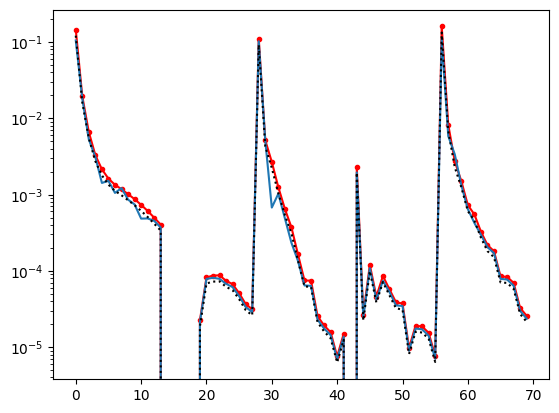

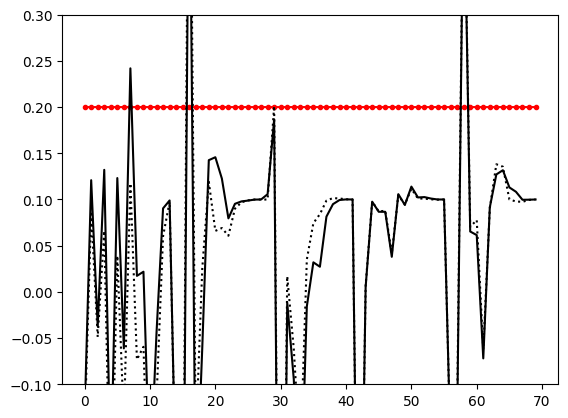

step: 43 0.34137248538087056
[[-3.3294171e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.0106829e-06  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.4863977e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.1781068e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2844155e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.9544078e-03]]
[-0.14230253  0.08035088 -0.06315114  0.08019985 -0.27304715  0.03292345
 -0.13256326  0.17128442 -0.03893023 -0.03976421 -0.27611876 -0.12219382
  0.06651987  0.09768762 -0.22708698 -0.36440432  0.6135952  -0.17836015
 -0.0023011   0.12575512  0.0844813   0.07790022  0.06486653  0.09165607
  0.09749436  0.09909858  0.09991843  0.10000385  0.10241117  0.19683895
 -0.67

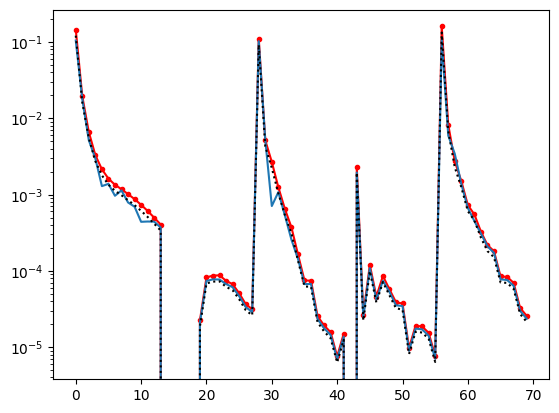

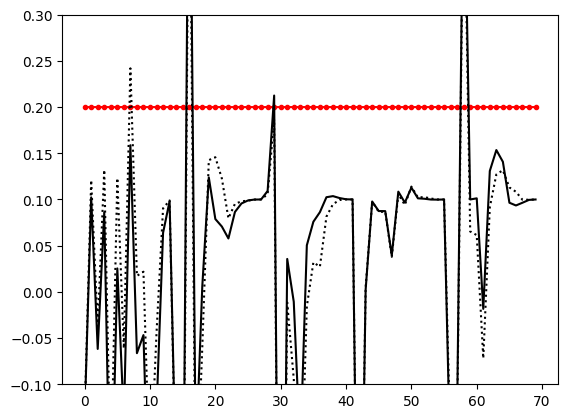

step: 46 0.324303861111827
[[-3.0759238e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.3232782e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.9119796e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.3075570e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2135347e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.3603131e-03]]
[-0.13119939  0.11777156 -0.05215387  0.11860792 -0.21983273  0.10853554
 -0.06906507  0.2526579   0.0093348   0.03052698 -0.22312917 -0.05793668
  0.08492962  0.09899362 -0.215968   -0.38905677  0.5441491  -0.25047457
 -0.05487705  0.14097139  0.14007255  0.11601597  0.07693539  0.09259021
  0.09685642  0.09872303  0.09987467  0.10000288  0.11030457  0.19750552
 -0.7080

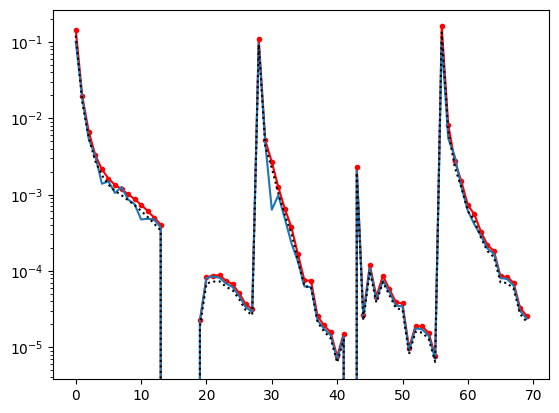

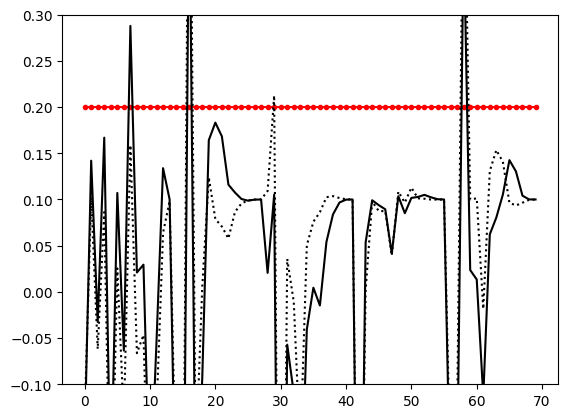

step: 49 0.30808866805623564
[[-3.3981687e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.2859947e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.8748351e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.7104667e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2883697e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -4.0317960e-03]]
[-0.16811824  0.10319597 -0.05557507  0.11654374 -0.28465617  0.02182036
 -0.13563721  0.1970947  -0.05767243 -0.04982762 -0.28767872 -0.12625343
  0.09764589  0.09874654 -0.26267412 -0.37701637  0.5517662  -0.19805086
 -0.040007    0.14303842  0.10580593  0.09892324  0.08613881  0.09870613
  0.09909301  0.09907692  0.0998975   0.10000239  0.03521649  0.15093124
 -0.69

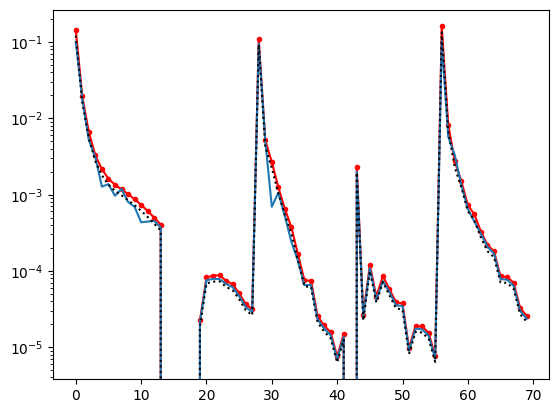

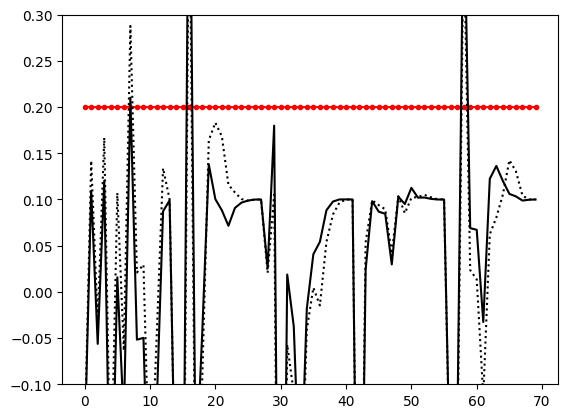

step: 52 0.29268423465342386
[[-4.0458617e-10  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.4024788e-12  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.7138581e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -7.6920761e-12
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.3933462e-10  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -7.2967602e-08]]
[-0.16873617  0.10936575 -0.05627692  0.12035393 -0.28888348  0.01577731
 -0.13936235  0.21020426 -0.05173369 -0.04976931 -0.29187194 -0.12902786
  0.08788054  0.10906451 -0.2718257  -0.36717218  0.55853677 -0.20235312
 -0.04221762  0.1298046   0.10192139  0.08865372  0.07187787  0.09165843
  0.09897763  0.11288532  0.10219923  0.09992804  0.02537316  0.1791118
 -0.690

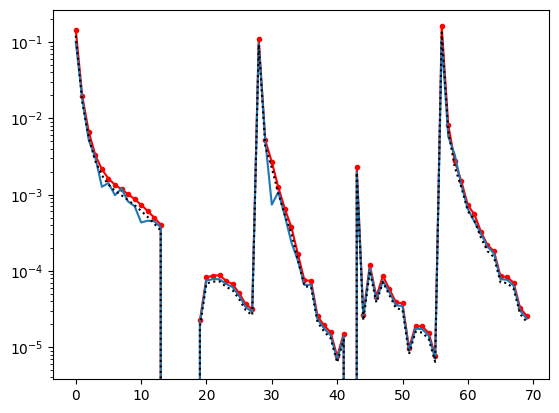

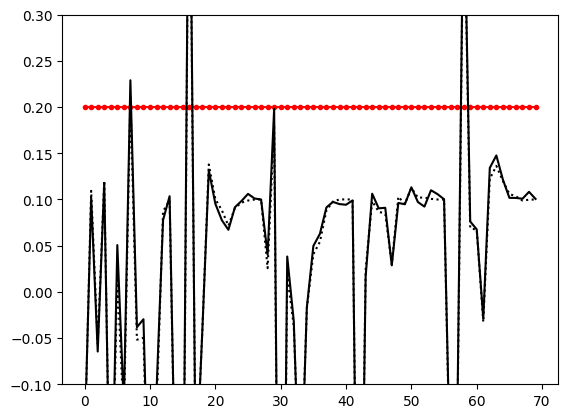

step: 55 0.27805002292075265
[[-3.0882020e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.0993595e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.7627438e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.0355917e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2770733e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.6820332e-03]]
[-0.16166183  0.11078663 -0.06240053  0.13235654 -0.24352388  0.12368115
 -0.0698889   0.270474    0.0007523   0.03214856 -0.24670304 -0.04556174
  0.08223271  0.10223904 -0.26666987 -0.36451256  0.5534883  -0.23159629
 -0.06495002  0.13682766  0.1153836   0.094667    0.07855058  0.09652751
  0.09976135  0.10426336  0.10075139  0.0999767   0.04073553  0.19866061
 -0.67

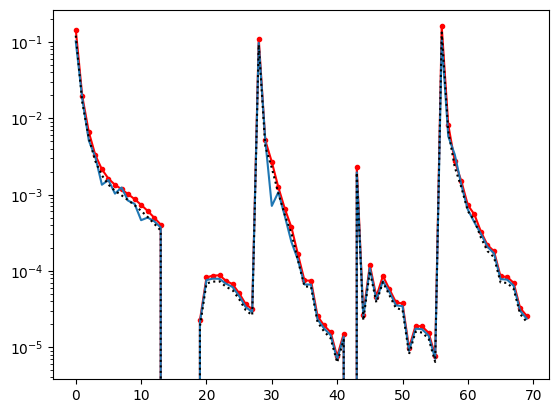

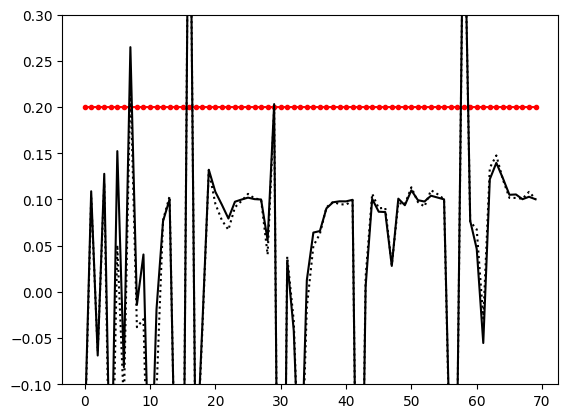

step: 58 0.264147521774715
[[-3.4413308e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.3525342e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.5026029e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.7579121e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.4747915e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.9671515e-03]]
[-0.14750086  0.08361398 -0.08782467  0.07201798 -0.2968931   0.0762443
 -0.14211057  0.18133344 -0.079067   -0.0282333  -0.2953329  -0.0833974
  0.05145252  0.09875068 -0.21653162 -0.3218512   0.67203647 -0.14710167
  0.02517315  0.11140567  0.03513906  0.03319262  0.05634038  0.09133337
  0.09902658  0.10168807  0.10032807  0.09999592  0.1116135   0.2802479
 -0.6601141

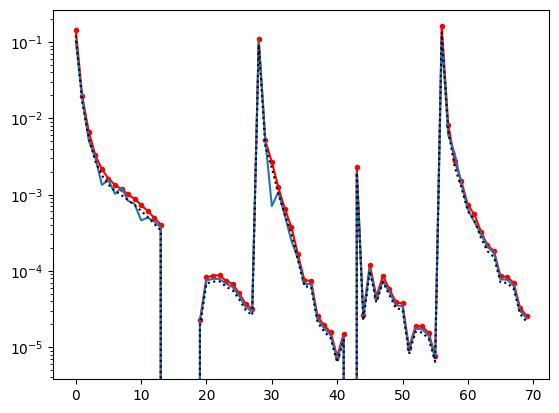

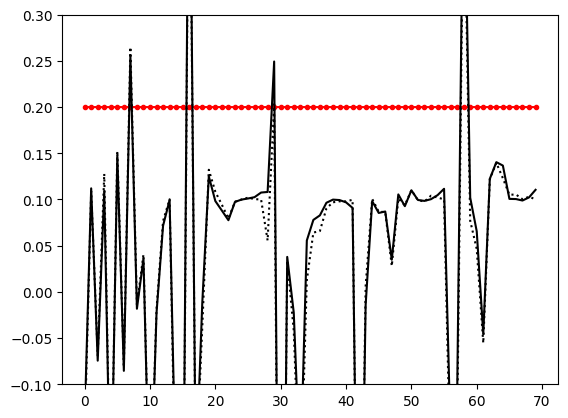

step: 61 0.2509401456859792
[[-3.2068187e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.1086947e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.6558434e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.4579688e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2843359e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.4577621e-03]]
[-0.14158435  0.10431911 -0.08129739  0.09539224 -0.28820208  0.1259195
 -0.11599265  0.2269221  -0.04823345  0.0036223  -0.28375977 -0.05294733
  0.06414402  0.09856606 -0.22634359 -0.35472694  0.6100103  -0.15344694
  0.01280779  0.11952561  0.0827424   0.08113581  0.07507635  0.09661956
  0.09965603  0.10070526  0.10187104  0.10562115  0.10825136  0.23742299
 -0.6823

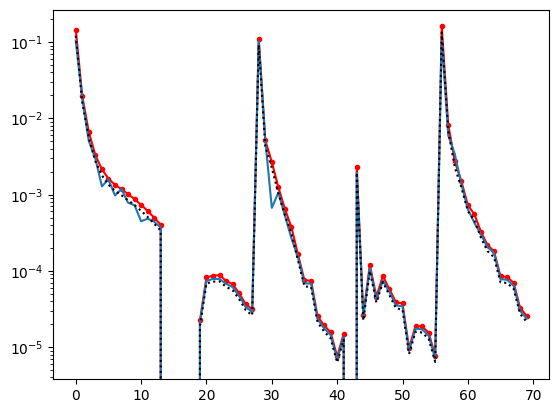

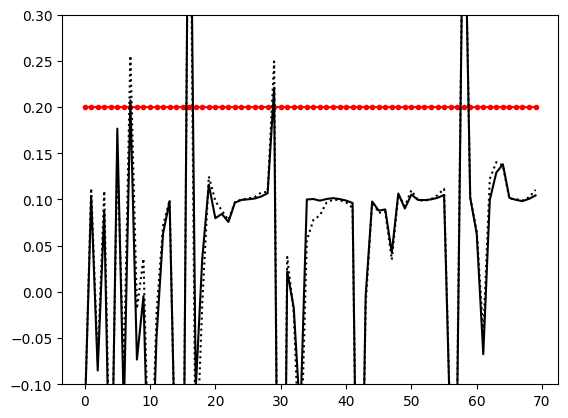

step: 64 0.23839313840168025
[[-2.7474700e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.4138762e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.0054474e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.8155781e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -9.9939462e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.3472308e-03]]
[-0.13839278  0.1121728  -0.08227299  0.09499138 -0.24867857  0.20267858
 -0.11321396  0.22402869 -0.05891136  0.02016765 -0.22925079 -0.00687134
  0.06934003  0.09824305 -0.22642368 -0.37125036  0.59229773 -0.10864706
  0.03239338  0.11853234  0.09493576  0.09828535  0.08180764  0.09835503
  0.09981447  0.09993552  0.10074675  0.10240409  0.10639899  0.21452078
 -0.71

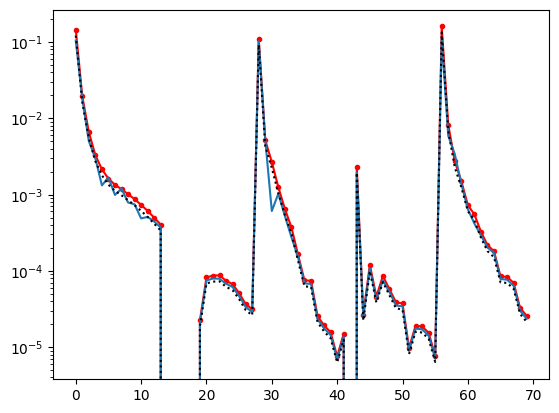

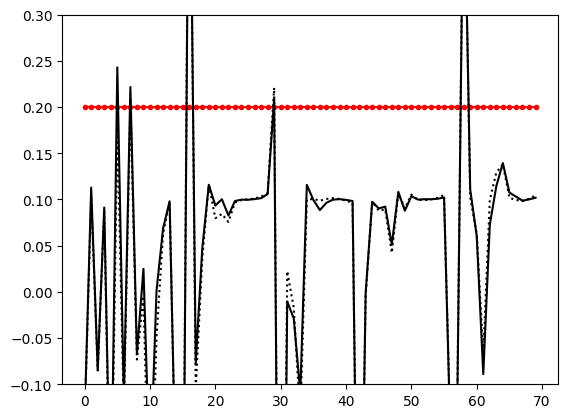

step: 67 0.22647348148159624
[[-3.1740594e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.0081782e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.6979805e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.9983224e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.3281072e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.8899134e-03]]
[-1.30378336e-01  1.05941556e-01 -9.09678042e-02  7.03336298e-02
 -3.04332495e-01  1.72568530e-01 -1.67215765e-01  1.80191398e-01
 -1.11187056e-01 -3.31116803e-02 -2.49313980e-01 -5.54006621e-02
  5.89743033e-02  9.76203308e-02 -1.91315129e-01 -3.54621917e-01
  6.21755719e-01 -2.65604295e-02  7.75040984e-02  1.07081741e-01
  6.84020072e-02  8.32484141e-02  7.76887462e-

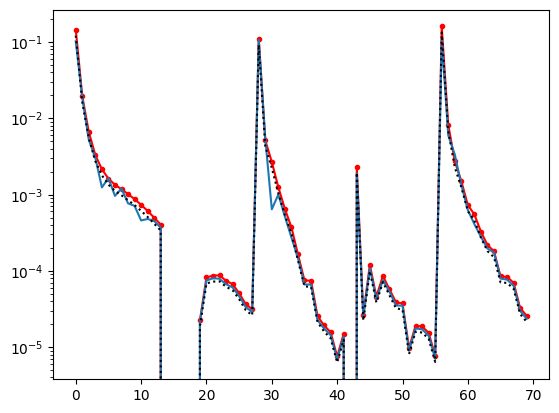

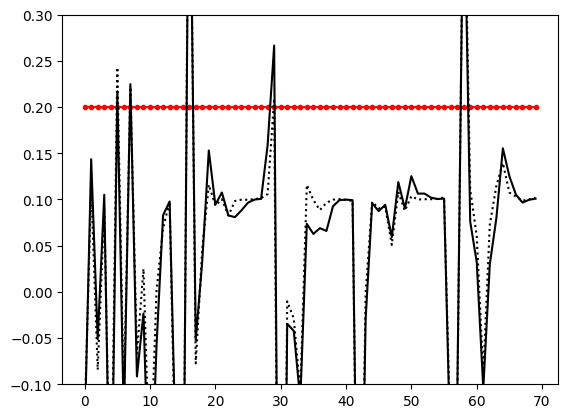

step: 70 0.2151498074075164
[[-3.7055623e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.5151712e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.5393446e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.9452808e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2574758e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.8041393e-03]]
[-0.1533266   0.1387433  -0.05297503  0.10560668 -0.28580338  0.25861368
 -0.1330297   0.23076221 -0.08735688 -0.01331066 -0.24021861 -0.04670233
  0.0804303   0.09788726 -0.19378684 -0.367685    0.5599059  -0.06111886
  0.02812899  0.14654616  0.09451782  0.10242455  0.08005229  0.08320703
  0.09022257  0.09710427  0.09990594  0.10050729  0.15191388  0.2527021
 -0.7076

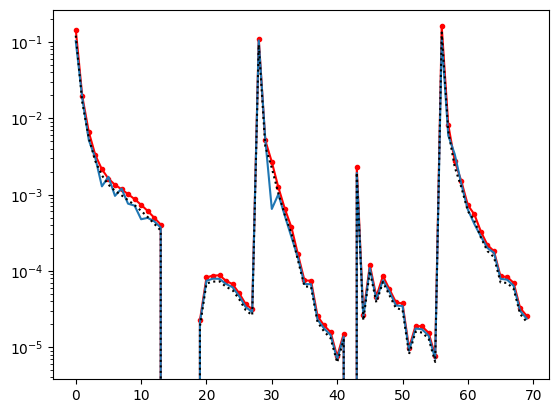

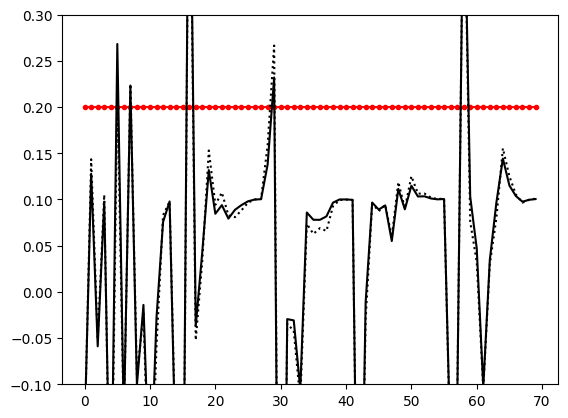

step: 73 0.2043923170371406
[[-3.1378910e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.2225193e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.7468067e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.8489493e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2799434e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.7483035e-03]]
[-0.14989617  0.12381393 -0.06208166  0.09260017 -0.29446414  0.26831496
 -0.14932422  0.21727909 -0.10752431 -0.01478994 -0.2183135  -0.02392437
  0.07341771  0.09777994 -0.20711091 -0.36052918  0.58798915 -0.02400596
  0.05200024  0.12610662  0.08015633  0.0905811   0.07832502  0.09017023
  0.09500798  0.09829613  0.09991046  0.10025042  0.13211346  0.22715446
 -0.712

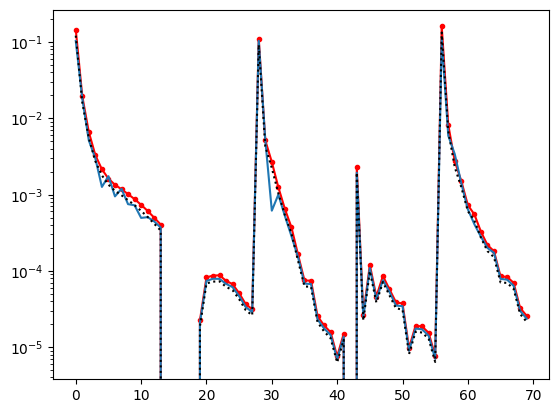

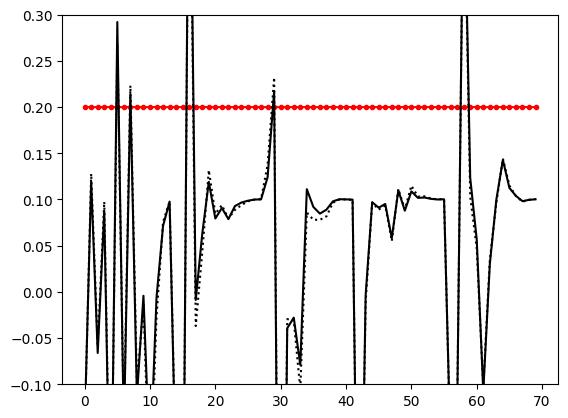

step: 76 0.19417270118528354
[[-3.1448719e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.2515453e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.6511593e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.5226508e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2197462e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.7546377e-03]]
[-1.46083519e-01  1.18511520e-01 -6.76240996e-02  8.57594535e-02
 -2.98580557e-01  3.10201854e-01 -1.57129645e-01  2.12572336e-01
 -1.15774475e-01  3.48447496e-03 -1.69080511e-01  5.45960432e-03
  7.11043477e-02  9.76948738e-02 -2.15002835e-01 -3.64708930e-01
  5.98976851e-01 -5.25146781e-04  6.84386864e-02  1.16594769e-01
  8.00720528e-02  9.21574384e-02  7.95467868e-

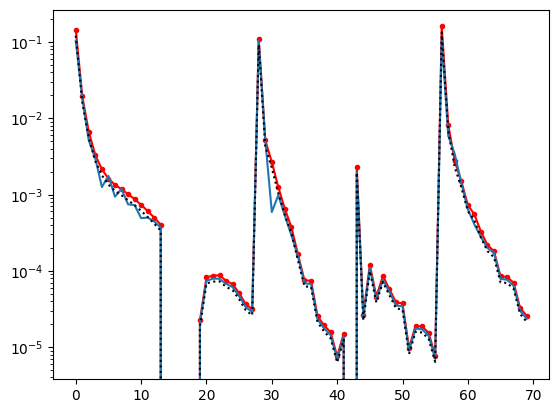

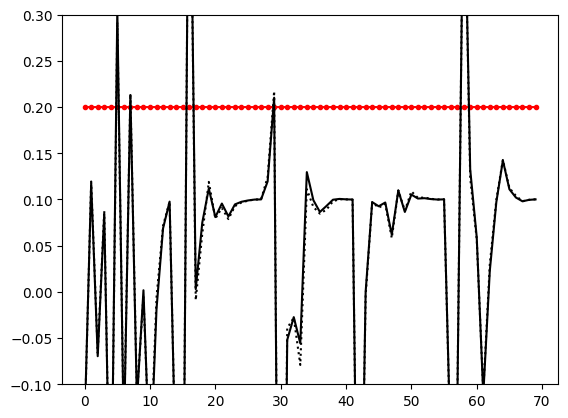

step: 79 0.18446406612601934
[[-3.1581294e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.9827311e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.6808179e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.1235462e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.3177196e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.7958084e-03]]
[-1.42651930e-01  1.17801316e-01 -7.03103840e-02  8.43891799e-02
 -2.94316053e-01  3.07823598e-01 -1.62364885e-01  2.14738294e-01
 -1.17787287e-01  4.43894370e-03 -2.01434523e-01 -2.12073326e-02
  6.85096383e-02  9.76722687e-02 -2.15799019e-01 -3.71348411e-01
  5.91703236e-01  4.24048305e-03  7.68201649e-02  1.10432982e-01
  8.19462538e-02  9.72332805e-02  8.25553015e-

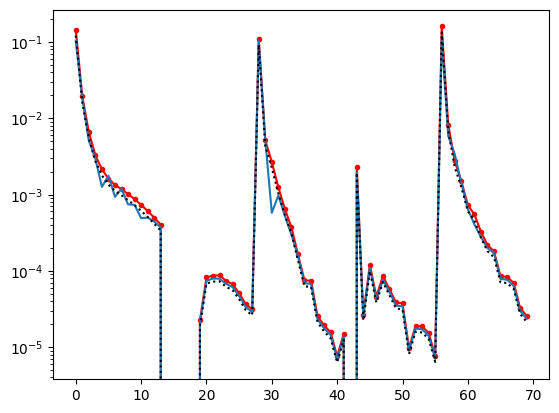

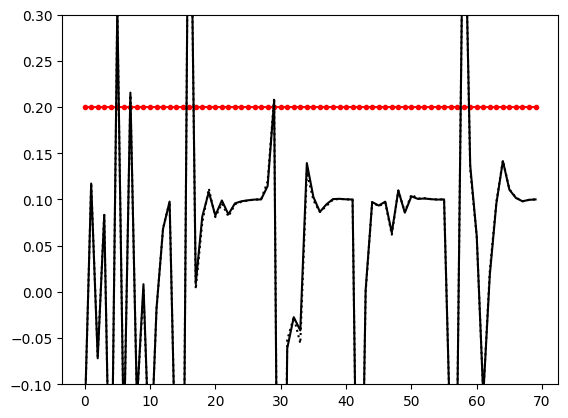

step: 82 0.17524086281971837
[[-3.1440351e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.9589120e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.6378714e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.9528018e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2871464e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.8060583e-03]]
[-0.14155288  0.11768727 -0.07218932  0.08366257 -0.2921363   0.3142397
 -0.1643377   0.21714027 -0.118798    0.01101371 -0.19562437 -0.01386305
  0.06856358  0.09769418 -0.21756658 -0.37467986  0.5871513   0.00826385
  0.08214391  0.10754974  0.08412205  0.10028031  0.08475097  0.09605455
  0.09821714  0.09913367  0.09990083  0.10003991  0.11418951  0.20761608
 -0.741

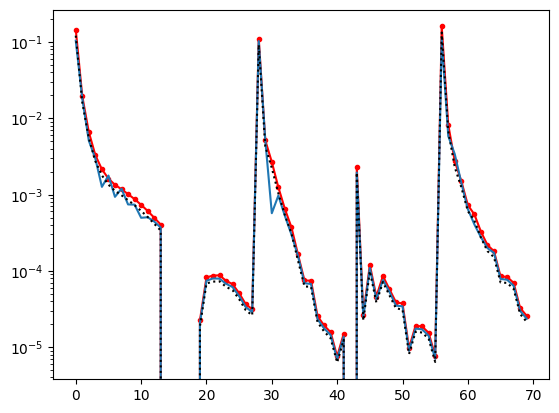

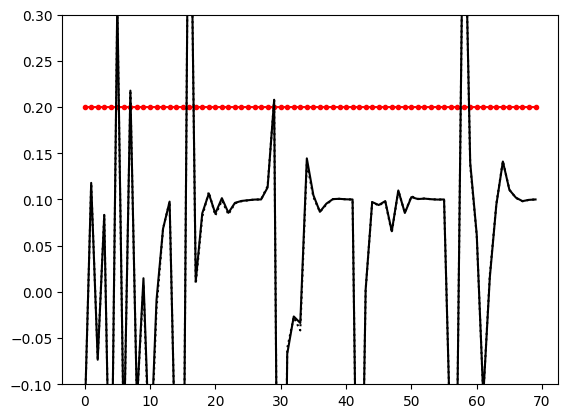

step: 85 0.16647881967873246
[[-3.1640753e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.9954344e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.6684694e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.9718207e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2953096e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.8133182e-03]]
[-0.1404866   0.11727434 -0.0743259   0.081495   -0.29828528  0.31520888
 -0.16891842  0.21651821 -0.12244186  0.01509755 -0.18758728 -0.00917357
  0.067931    0.09764371 -0.21806258 -0.3768538   0.5860272   0.01471078
  0.08727465  0.10563627  0.08424063  0.10135958  0.08549683  0.09635379
  0.09845297  0.09918084  0.09989773  0.10002404  0.11172026  0.20704174
 -0.74

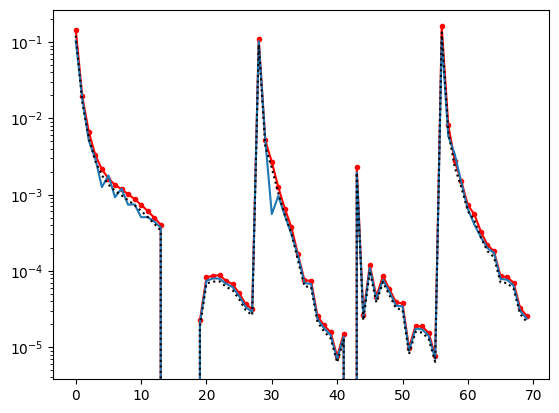

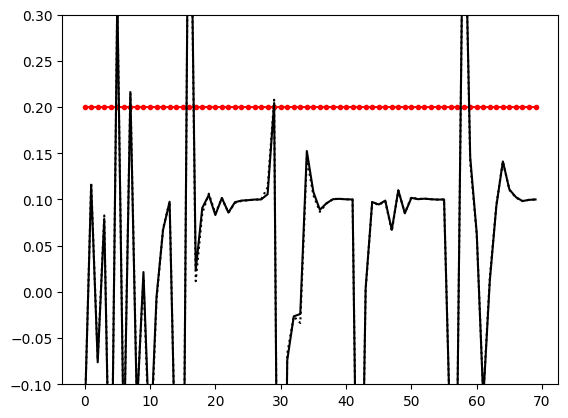

step: 88 0.15815487869479583
[[-3.1968921e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.9554110e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.6535560e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.8409125e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2823784e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.8271297e-03]]
[-0.14051801  0.11620159 -0.07683105  0.07865405 -0.29344362  0.33274043
 -0.17388828  0.215483   -0.12674072  0.02631748 -0.1673753  -0.00259849
  0.06710861  0.09755813 -0.223265   -0.38055348  0.5874836   0.02393044
  0.09039864  0.10506895  0.08453073  0.10292656  0.08648504  0.09736066
  0.09892751  0.09924813  0.09989762  0.10001548  0.10527487  0.20431376
 -0.75

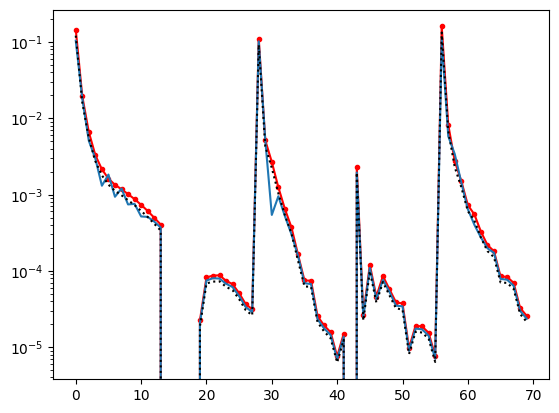

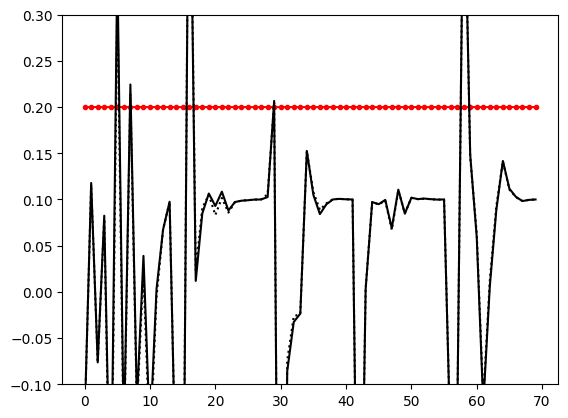

step: 91 0.15024713476005602
[[-3.2570551e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.7169670e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.6879045e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.9840652e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.3288719e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.9196247e-03]]
[-1.48267299e-01  9.92685482e-02 -8.73256773e-02  5.05531654e-02
 -2.96741366e-01  3.06263059e-01 -1.95613503e-01  1.78450853e-01
 -1.53343394e-01 -6.89543085e-05 -1.86963782e-01 -3.47719491e-02
  5.19119725e-02  9.67361182e-02 -2.22697586e-01 -3.74989241e-01
  6.13174856e-01  4.98904400e-02  1.23433150e-01  9.63908583e-02
  5.95482551e-02  8.33365470e-02  7.33860806e-

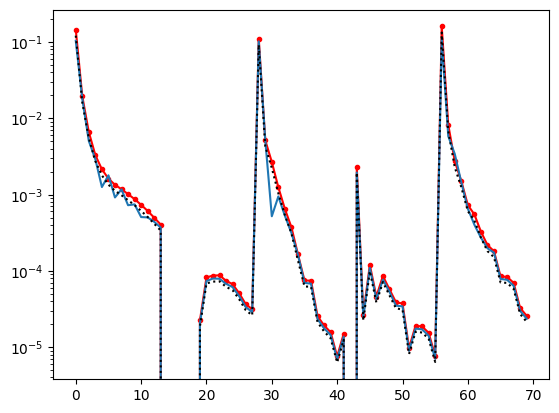

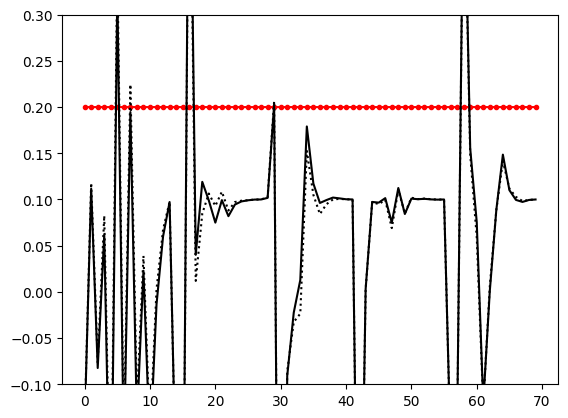

step: 94 0.14273477802205323
[[-3.2349879e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.5628265e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.5003786e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.2979336e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.3656721e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.7447580e-03]]
[-1.42372876e-01  1.15245990e-01 -8.07989091e-02  6.65045306e-02
 -2.75629014e-01  3.48461956e-01 -1.74385816e-01  2.02630863e-01
 -1.34320781e-01  3.26798558e-02 -1.57945186e-01 -4.92372550e-03
  6.25147969e-02  9.73873064e-02 -2.22551703e-01 -3.88008654e-01
  5.91973782e-01  3.19448784e-02  1.13201432e-01  1.00652047e-01
  8.13573152e-02  1.04471780e-01  8.42270777e-

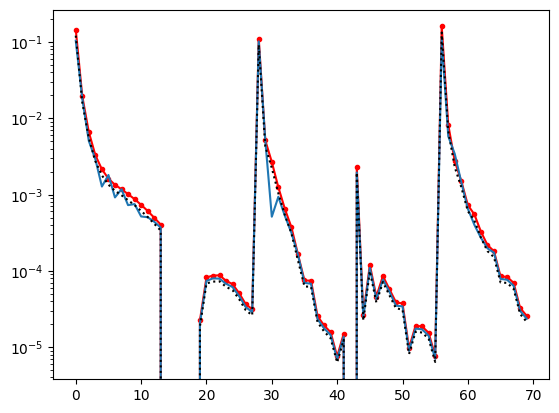

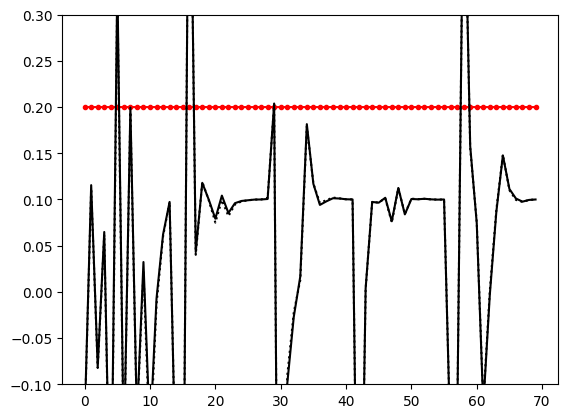

step: 97 0.13559803912095056
[[-3.0378740e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.6646393e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.5859240e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.0762197e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.3151874e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.8246305e-03]]
[-0.1408253   0.11678241 -0.08119037  0.06596051 -0.2818347   0.3488769
 -0.17928706  0.20157292 -0.13740388  0.03791502 -0.1469794  -0.00337113
  0.06299642  0.09736859 -0.22292866 -0.38979098  0.5890652   0.04116305
  0.1158246   0.10036492  0.08157358  0.10617655  0.08656113  0.09650842
  0.09857357  0.09917451  0.09988513  0.10000601  0.09999594  0.20368347
 -0.771

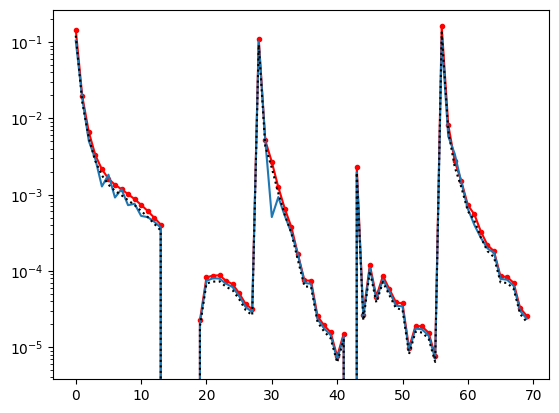

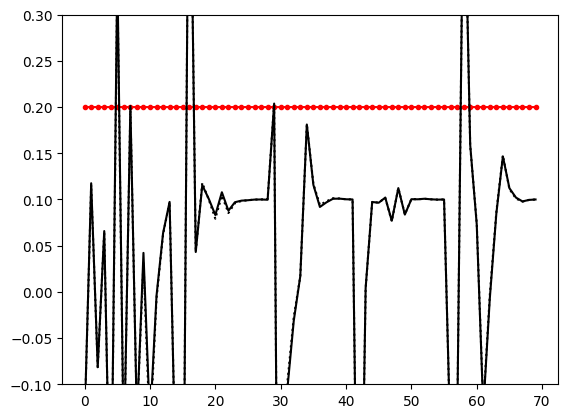

step: 100 0.12881813716490303
[[-3.1166353e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -7.8908874e-07  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.6411094e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.0619643e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2605374e-04  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.8300464e-03]]
[-0.13981737  0.1178351  -0.08189188  0.06499485 -0.29155645  0.34638947
 -0.18626295  0.19965728 -0.14222082  0.04098368 -0.14477864 -0.00773746
  0.06337556  0.09735064 -0.2232516  -0.39068782  0.5871087   0.04638808
  0.11667346  0.10027556  0.08291893  0.10801921  0.08827649  0.09709288
  0.09872966  0.09919539  0.09988596  0.10000504  0.09976453  0.2039557
 -0.77

In [22]:
from datetime import datetime, timedelta
from jax.scipy.optimize import minimize

from multiprocessing.pool import ThreadPool as Pool 
pool = Pool() #jax pmap? check re-compilation times?
pmap = pool.map

#method = 'L-BFGS-B'
method = "l-bfgs-experimental-do-not-rely-on-this"
θ_rtol = 1e-5
z_rtol = 1e-5

θ_tol = 1e-5
z_tol = 1e-6

history = []
α=0.7
beta = 0.25

θ̃ = start_point
θ = start_point# if result.θ is not None else θ_start)
θL = start_point
Nθ = len(ravel_θ(θ̃))
time = timedelta(0)
for i in range(1, maxsteps+1):
        print("step:",i,α)
        t0 = datetime.now()

        if i > 1:
            xs = [x_data] + [prob.sample_x_z(_rng, θ)[0] for _rng in _split_rng(rng,nsims)]
            θ_tol = np.sqrt(-np.diag(H̃_inv_post)) * θ_rtol

        if i > 2:
            Δθ̃ = ravel_θ(history[-1]["θ̃"])- ravel_θ(history[-2]["θ̃"])
          #  if np.sqrt(-np.inner(Δθ̃, np.inner(np.linalg.pinv(history[-1]["H̃_inv_post"]), Δθ̃))) < θ_rtol:
           #     break

        # MUSE gradient
        def get_MAPs(x_z):
            x, ẑ_prev = x_z
            result = prob.z_MAP_and_score(x, ẑ_prev, θ, method=method, z_tol=z_tol, θ_tol=θ_tol)
            
            return result

        MAPs = list(pmap(get_MAPs, zip(xs, ẑs)))

        ẑs = [MAP.z for MAP in MAPs]
   #     if save_MAP_history:
    #        MAP_history_dat, *MAP_history_sims = [MAP.history for MAP in MAPs]
        s_MAP_dat, *s_MAP_sims = [MAP.s for MAP in MAPs]
        s̃_MAP_dat, *s̃_MAP_sims = [MAP.s̃ for MAP in MAPs]
        s̃_MUSE = unravel_θ(ravel_θ(s̃_MAP_dat) - np.nanmean(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
        s̃_prior, H̃_prior = gradθ_hessθ_logPrior(θ̃, transformed_θ=True)
        s̃_post = unravel_θ(ravel_θ(s̃_MUSE) + ravel_θ(s̃_prior))

        # print(s̃_MAP_sims)
        # H̃_inv_like_sims = np.diag(-1 / np.nanvar(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
        epsilon = 1e-8  # A small value to avoid division by zero
        variance = np.nanvar(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0)
        variance += epsilon  # Add epsilon to the variance to prevent zero values
        H̃_inv_like_sims = np.diag(-1 / variance)
        print(H̃_inv_like_sims)
        
       # try:
        # H̃_inv_post = np.linalg.pinv(np.linalg.pinv(H̃_inv_like_sims) + ravel_θ(H̃_prior).reshape(Nθ,Nθ))
        H̃_inv_post = np.linalg.pinv(np.linalg.pinv(H̃_inv_like_sims) + ravel_θ(H̃_prior).reshape(Nθ,Nθ))
        #except:
        #    print("error on Hessian inversion calc, prior ignored and trying again...")
       # H̃_inv_post = H̃_inv_like_sims
        t = datetime.now() - t0
        time += t

        history.append({
            "t":t, "θ̃":θ̃, "θ":θ,
            "s_MAP_dat": s_MAP_dat, "s_MAP_sims": s_MAP_sims,
            "s̃_MAP_dat": s̃_MAP_dat, "s̃_MAP_sims": s̃_MAP_sims, 
            "s̃_MUSE": s̃_MUSE,
            "s̃_prior": s̃_prior, "s̃_post": s̃_post, 
            "H̃_inv_post": H̃_inv_post, "H̃_prior": H̃_prior, 
            "H̃_inv_like_sims": H̃_inv_like_sims,
            "θ_tol": θ_tol,
        #    "MAP_history_dat": MAP_history_dat, 
         #   "MAP_history_sims": MAP_history_sims,
        })
        θ̃update = np.clip((np.inner(H̃_inv_post, ravel_θ(s̃_post))),-jnp.abs(ravel_θ(θ̃)*beta),jnp.abs(ravel_θ(θ̃)*beta))
        θ̃ = unravel_θ((ravel_θ(θ̃) - α * θ̃update))
        θ = θ̃
        print(((θ-tf_cut_flat)/tf_cut_flat))
        #print(θ)
        if i%3==0:
            plt.semilogy(start_point,"r.-")
            plt.plot(θ)
            plt.plot(tf_cut_flat,"k:")
            plt.show()
            
            
            plt.plot((start_point-tf_cut_flat)/tf_cut_flat,"r.-")
            plt.plot((θ-tf_cut_flat)/tf_cut_flat,"k")
            plt.plot((θL-tf_cut_flat)/tf_cut_flat,"k:")
    
            plt.ylim([-.1,.3])
            plt.show()
            
            θL = θ
            #LR decay
            α *= 0.95

In [24]:
#as you can see, convergence properties are wonky, takes a bit of time to start moving... 
#Should converge if you have the patients to let it run a couple of hours


In [25]:
#Now lets try to calculate the covariance! :D

In [23]:
s_MAP_sims = history[-1]["s_MAP_sims"]
_, *z_MAP_sims = ẑs

In [24]:
def z_MAP_guess_from_truth(x, z, θ):
        return unravel_z(0 * ravel_z(z))
    
nsims = 4
    
def get_J(
        result = None,
        θ = None,
        θ_tol = None,
        z_tol = None,
        method = None,
        rng = None,
        nsims = 10, 
        pmap = map,
        progress = False, 
        skip_errors = False,
    ):

        nsims_remaining = nsims 

        if nsims_remaining > 0:
            print(nsims_remaining)
            t0 = datetime.now()

            def get_s_MAP(rng):
                    (x, z) = prob.sample_x_z(rng, θ)
                    # if np.isnan(x).any() or np.isnan(z).any():
                    #     print("NaN detected in sampled (x, z)")
                    #     return None                    
                    z_MAP_guess = prob.z_MAP_guess_from_truth(x, z, θ)
                    # if np.isnan(z_MAP_guess).any():
                    #     print("NaN detected in z_MAP_guess!")
                    #     return None

                    #     result = prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol)
                    #     if np.isnan(result.s).any():
                    #         print("NaN detected in s_MAP!")
                    #         return None
                    return prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).s
                

            rngs = _split_rng(rng, nsims_remaining)
            s_MAP_sims.extend(s for s in pmap(get_s_MAP, rngs) if s is not None)

#            time += datetime.now() - t0

        stacked_s = np.stack(list(map(ravel_θ, s_MAP_sims)))
        print("Stacked s_MAP_sims shape:", stacked_s.shape)
        print("Stacked s_MAP_sims values:", stacked_s)
        
        if np.isnan(stacked_s).any():
            print("NaN detected in stacked_s before computing J!")
            exit()
        J = np.atleast_2d(np.cov(np.stack(list(map(ravel_θ, s_MAP_sims))), rowvar=False))
        return J



In [25]:
J = get_J(rng=rng,θ =θ,method=method, θ_tol=θ_tol, z_tol=z_tol)

10
Stacked s_MAP_sims shape: (20, 70)
Stacked s_MAP_sims values: [[3.9981658e+03 8.0149516e+04 3.5458250e+05 ... 2.3330934e+04
  3.8122512e+03 2.9855240e+02]
 [4.2904482e+03 8.1019492e+04 3.5236203e+05 ... 2.3892762e+04
  3.9251904e+03 3.0379068e+02]
 [4.0348501e+03 8.1037312e+04 3.6308350e+05 ... 2.3632408e+04
  3.7838555e+03 2.8572543e+02]
 ...
 [4.1653291e+03 7.7475812e+04 3.4007325e+05 ... 2.3065609e+04
  3.6655771e+03 2.5535004e+02]
 [4.4255176e+03 7.9417758e+04 3.5367622e+05 ... 2.4249861e+04
  3.9762466e+03 3.0720792e+02]
 [4.3648369e+03 8.0113469e+04 3.5640481e+05 ... 2.4622137e+04
  3.9969399e+03 3.1109985e+02]]


In [26]:
J

array([[2.10455752e+07, 2.52292211e+08, 3.43817274e+08, ...,
        1.03294673e+08, 1.95006372e+07, 1.96569381e+06],
       [2.52292211e+08, 3.09543164e+09, 4.19305911e+09, ...,
        1.27381784e+09, 2.38709150e+08, 2.40107114e+07],
       [3.43817274e+08, 4.19305911e+09, 5.73694733e+09, ...,
        1.71611783e+09, 3.22697578e+08, 3.25343822e+07],
       ...,
       [1.03294673e+08, 1.27381784e+09, 1.71611783e+09, ...,
        5.31222283e+08, 9.88265445e+07, 9.92405309e+06],
       [1.95006372e+07, 2.38709150e+08, 3.22697578e+08, ...,
        9.88265445e+07, 1.84804857e+07, 1.85821266e+06],
       [1.96569381e+06, 2.40107114e+07, 3.25343822e+07, ...,
        9.92405309e+06, 1.85821266e+06, 1.86992404e+05]])

In [27]:
Hs = []

In [28]:
def pjacobian(f, x, step, pmap=map, pbar=None):
    print(step,x)
    step = step + np.array(0 * x) # make array if scalar

    def column(i):
    
        def v(ε):
            ε_vec = np.array(0 * x)
            ε_vec[i] = ε
            v = f(x + ε_vec)
            if pbar: pbar.update()
            return v

        return (v(step[i]) - v(-step[i])) / (2 * step[i])

    return np.array(list(pmap(column, range(len(x)))))

In [29]:
#This takes a while, roughly an hour or two... Can probably parallelize it across GPUs if you want.

from tqdm import tqdm
from jax.scipy.sparse.linalg import cg

step = None
skip_errors = False
def _get_H_i_old(rng, z_MAP_guess_fid, *, θ, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):
    
    # for each sim, do one fit at fiducial which we'll
    # reuse as a starting point when fudging θ by +/-ϵ
    θfid = θ
    (x, z) = prob.sample_x_z(rng, θfid)
    if z_MAP_guess_fid is None:
        z_MAP_guess = _MAP_guess_from_truth(x, z, θfid)
        z_MAP_guess_fid = z_MAP_and_score(x, z_MAP_guess, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).z

    def get_s_MAP(θvec):
        θ = unravel_θ(θvec)
        (x, _) = prob.sample_x_z(copy(rng), θ)
        return ravel_θ(prob.z_MAP_and_score(x, z_MAP_guess_fid, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).s)

    return pjacobian(get_s_MAP, ravel_θ(θfid), step)


def _get_H_i(rng, z_MAP, *, θ, implicit_diff_cgtol=1e-3, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):

        #implicit implementation..
        cg_kwargs = dict(tol=implicit_diff_cgtol)

        (x, z) = prob.sample_x_z(rng, θ)
        if z_MAP is None:
            z_MAP_guess = z_MAP_guess_from_truth(x, z, θ)
            z_MAP = prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).z

        θ_vec, z_MAP_vec = ravel_θ(θ), ravel_z(z_MAP)
        #unravel_θ, unravel_z = unravel_θ, unravel_z

        # non-implicit-diff term
        H1 = jacfwd(
            lambda θ1: grad(
                lambda θ2: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], z_MAP, unravel_θ(θ2))
            )(θ_vec)
        )(θ_vec)

        # term involving dzMAP/dθ via implicit-diff (w/ conjugate-gradient linear solve)
        dFdθ = jacfwd(
            lambda θ: grad(
                lambda z: prob.logLike(x, unravel_z(z), unravel_θ(θ))
            )(z_MAP_vec)
        )(θ_vec)
        dFdθ1 = jacfwd(
            lambda θ1: grad(
                lambda z: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], unravel_z(z), θ)
            )(z_MAP_vec)
        )(θ_vec)
        inv_dFdz_dFdθ1 = vmap(
            lambda vec: cg(
                lambda vec: jvp(lambda z: grad(lambda z: prob.logLike(x, unravel_z(z), θ))(z), (z_MAP_vec,), (vec,))[1], 
                vec, 
                **cg_kwargs
            )[0], 
            in_axes=1, out_axes=1
        )(dFdθ1)
        H2 = -dFdθ.T @ inv_dFdz_dFdθ1
        return H1 + H2

Hs = []

nsims_remaining = nsims  #- len(result.Hs)

z_MAP_sims = z_MAP_sims[:4]

if nsims_remaining > 0:

    # default to finite difference step size of 0.1σ with σ roughly
    # estimated from s_MAP_sims sims, if we have them
    if step is None:
        if len(s_MAP_sims) > 0:
            step = 0.1 / np.std(np.stack(list(map(ravel_θ, s_MAP_sims))), axis=0)
        else:
            step = 1e-5
    
    Nθ = len(ravel_θ(θ))
    pbar = partial(tqdm, total=nsims_remaining, desc="get_H", disable=(True))

    t0 = datetime.now()
    rngs = _split_rng(rng, nsims)[-nsims_remaining:]
    z_MAP_sims = (z_MAP_sims + [None]*(max(0, nsims - len(z_MAP_sims))))[-nsims_remaining:]
    _get_H_ii = partial(_get_H_i, θ=θ, method=method, θ_tol=θ_tol, z_tol=z_tol, step=step, skip_errors=skip_errors)
    Hs.extend(H for H in pbar(map(lambda args: _get_H_ii(*args), zip(rngs, z_MAP_sims)) )if H is not None)
   # result.time += datetime.now() - t0

avg = np.mean#np.median if use_median else np.mean
H = avg(np.array(Hs), axis=0)

In [30]:
Hs[0]

Array([[1.9096125e+04, 5.4559000e+04, 5.2958000e+04, ..., 6.2791270e+03,
        3.9863438e+03, 4.4127344e+02],
       [5.5206250e+04, 1.4672280e+06, 2.2551360e+06, ..., 1.8881800e+05,
        2.9276500e+04, 5.6148750e+03],
       [5.2695250e+04, 2.3024960e+06, 1.4144224e+07, ..., 5.5472300e+05,
        2.1812500e+04, 9.6153125e+03],
       ...,
       [8.6899688e+03, 1.8339050e+05, 6.0178200e+05, ..., 2.8816500e+05,
        3.8545750e+04, 6.8343359e+03],
       [1.3905938e+03, 2.7324312e+04, 8.2220500e+04, ..., 5.0941000e+04,
        7.7708125e+03, 2.1890127e+03],
       [9.9591309e+01, 1.6729375e+03, 5.8934844e+03, ..., 4.7974688e+03,
        6.9080078e+02, 3.5728125e+02]], dtype=float32)

In [31]:
import scipy as sp

Nθ = len(ravel(θ))

H_prior = -ravel(prob.gradθ_hessθ_logPrior(θ, transformed_θ=False)[1]).reshape(Nθ,Nθ)
Σ_inv = H.T @ np.linalg.pinv(J) @ H + H_prior
Σ = np.linalg.pinv(Σ_inv)

try:
    if θ is not None:
        if Nθ == 1:
            dist = sp.stats.norm(ravel(θ), np.sqrt(Σ[0,0]))
        else:
            dist = sp.stats.multivariate_normal(ravel(θ), Σ)
except:
    print("likely error in covariance... proceed with caution!")

In [32]:
cond_number = np.linalg.cond(J)
print(f"Condition number of J: {cond_number}")
if cond_number > 1e12:
    print("Warning: J is nearly singular!")

Condition number of J: 1.2524416372238944e+23


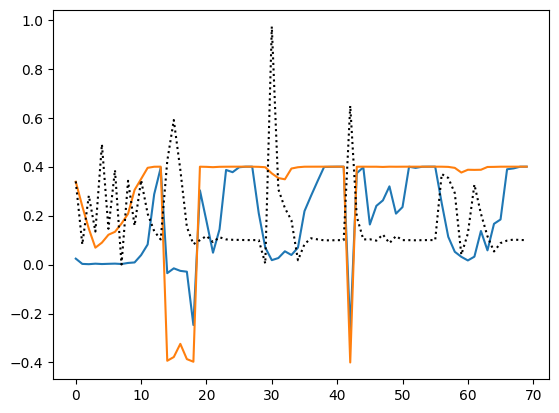

In [33]:
plt.plot(1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat)
plt.plot(np.sqrt(np.diag(Σ))/tf_cut_flat)

plt.plot(abs((start_point-θ)/tf_cut_flat),"k:")

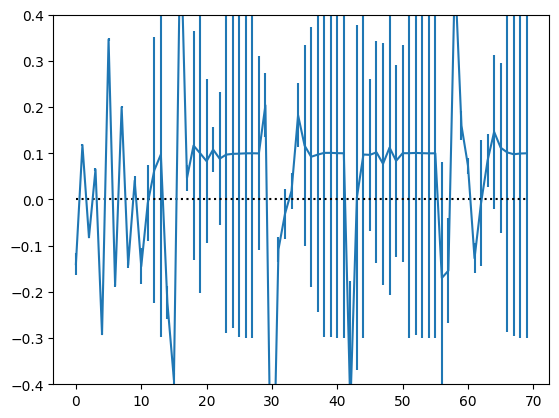

In [34]:
#need to run optimization for longer, since thsoe smaller scale modes in each mu-bin are not converged...
plt.errorbar(np.arange(len(tf_cut_flat)),(θ-tf_cut_flat)/tf_cut_flat,yerr=np.abs(1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat))
plt.plot(np.arange(len(tf_cut_flat)),np.arange(len(tf_cut_flat))*0.0,"k:")
plt.ylim(-0.4,0.4)
plt.show()

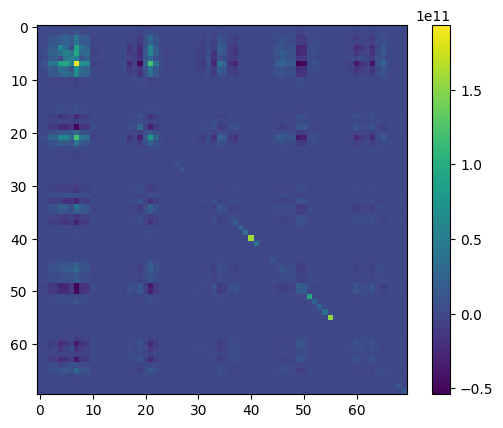

In [35]:
imshow(Σ_inv)
colorbar()